DMI_MSP2.1MA_3_LONG MARK_20X_SEC 1_LEFT HILUS_21 DAY.czi
DMI_MSP2.1MA_3_LONG MARK_20X_SEC 1_RIGHT HILUS_21 DAY.czi
DMI_MSP2.1MA_3_LONG MARK_20X_SEC 2_LEFT HILUS_21 DAY.czi
DMI_MSP2.1MA_3_LONG MARK_20X_SEC 2_RIGHT HILUS_21 DAY.czi
DMI_SC109.3M_2_DOUBLE MARK__20X_SEC 1_LEFT HILUS_21 DAY.czi
DMI_SC109.3M_2_DOUBLE MARK__20X_SEC 1_RIGHT HILUS_21 DAY.czi
DMI_SC109.3M_2_DOUBLE MARK__20X_SEC 2_LEFT HILUS_21 DAY.czi
DMI_SC109.3M_2_DOUBLE MARK__20X_SEC 2_RIGHT HILUS_21 DAY.czi
DMI_SC110.1M_3_UNMARKED__20X_SEC 1_LEFT HILUS_21 DAY.czi
DMI_SC110.1M_3_UNMARKED__20X_SEC 1_RIGHT HILUS_21 DAY.czi
DMI_SC110.1M_3_UNMARKED__20X_SEC 2_LEFT HILUS_21 DAY.czi
DMI_SC110.1M_3_UNMARKED__20X_SEC 2_RIGHT HILUS_21 DAY.czi
DMI_UN1_3_UNMARKED_20X_SEC 2_LEFT HILUS_21 DAY.czi
DMI_UN1_3_UNMARKED_20X_SEC1_LEFT HILUS_21 DAY.czi
DMI_UN1_3_UNMARKED_20X_SEC1_RIGHT HILUS_21 DAY.czi
DMI_UN1_3_UNMARKED_20X_SEC2_RIGHT HILUS_21 DAY.czi
FLX_SC109.3M_1_SINGLE MARK__20X_SEC 1_LEFT HILUS_21 DAY.czi
FLX_SC109.3M_1_SINGLE MARK__20X_SEC

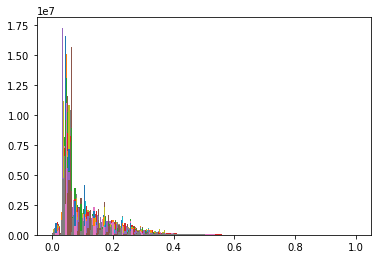

In [37]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import smorph.util.autocrop as ac
from os import getcwd, listdir, mkdir, path
from time import time
# from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt
import skimage

ROOT = 'Datasets'

SECTIONS = [
    'Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_21 DAYS/allImg/HILUS'
]

params = {'LOW_THRESH': .34,
          'HIGH_THRESH': .4,
          'SELECT_ROI': True,
          'NAME_ROI': 'HilusConEQ',
          'LOW_VOLUME_CUTOFF': 200,  # filter noise/artifacts
          'HIGH_VOLUME_CUTOFF': 1e9,  # filter cell clusters
          'OUTPUT_TYPE': 'both'
}

start = time()
hists = [[], [], [], []]

ref = None

for section in SECTIONS:
    for file in listdir(ROOT + '/' + section):
        print(file)
        if not file.startswith('.') and file.endswith('.czi') and 'HILUS' in file:  # skip hidden files
            try:
                CONFOCAL_TISSUE_IMAGE = ROOT + '/' + section + '/' + file

                original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)

                # 2. Non-local means denoising using auto-calibrated parameters
                if original.ndim == 2:
                    original = (original - original.min()) / (original.max() - original.min())
                    
                    original = np.expand_dims(original, 0)

                # deconvolved = ac.deconvolve(original, CONFOCAL_TISSUE_IMAGE, iters=10)
                # denoiser = ac.calibrate_nlm_denoiser(deconvolved)
                # denoise_parameters = denoiser.keywords['denoiser_kwargs']
                # print(denoise_parameters)
                # denoised = ac.denoise(deconvolved, denoise_parameters)
                # Adaptive Equalization
                img_adapteq = exposure.equalize_adapthist(original, clip_limit=0.03)
                if ref is None:
                    ref = img_adapteq
                denoised = skimage.exposure.match_histograms(img_adapteq, ref)
                # denoised = deconvolved
                n, _, _ = plt.hist(denoised.ravel()[denoised.ravel() > 0], bins=256)
                if 'DMI' in file:
                    hists[0].append(n)
                elif 'FLX' in file:
                    hists[1].append(n)
                elif 'HALO' in file:
                    hists[2].append(n)
                else:
                    hists[3].append(n)

            except Exception as e:
                print(str(e))

print('Elapsed:', time() - start, 'secs')


In [29]:
on_colab = False
import napari
# Helper function
def view_3D(*args):
    """Views a 3D image."""
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0], ndisplay=3)
            for itr in range(1, n_images):
                if args[itr]['data'].max() > 1 and args[itr]['data'].max() % 1 == 0:
                    if 'colormap' in args[itr].keys():
                        del args[itr]['colormap']
                    if 'gamma' in args[itr].keys():
                        del args[itr]['gamma']
                    viewer.add_labels(**args[itr])
                else:
                    viewer.add_image(**args[itr])

In [35]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
{'data': denoised, 'colormap': 'gray', 'name': 'denoised'},
{'data': ref, 'colormap': 'gray', 'name': 'ref'})

(0.0, 40.0)

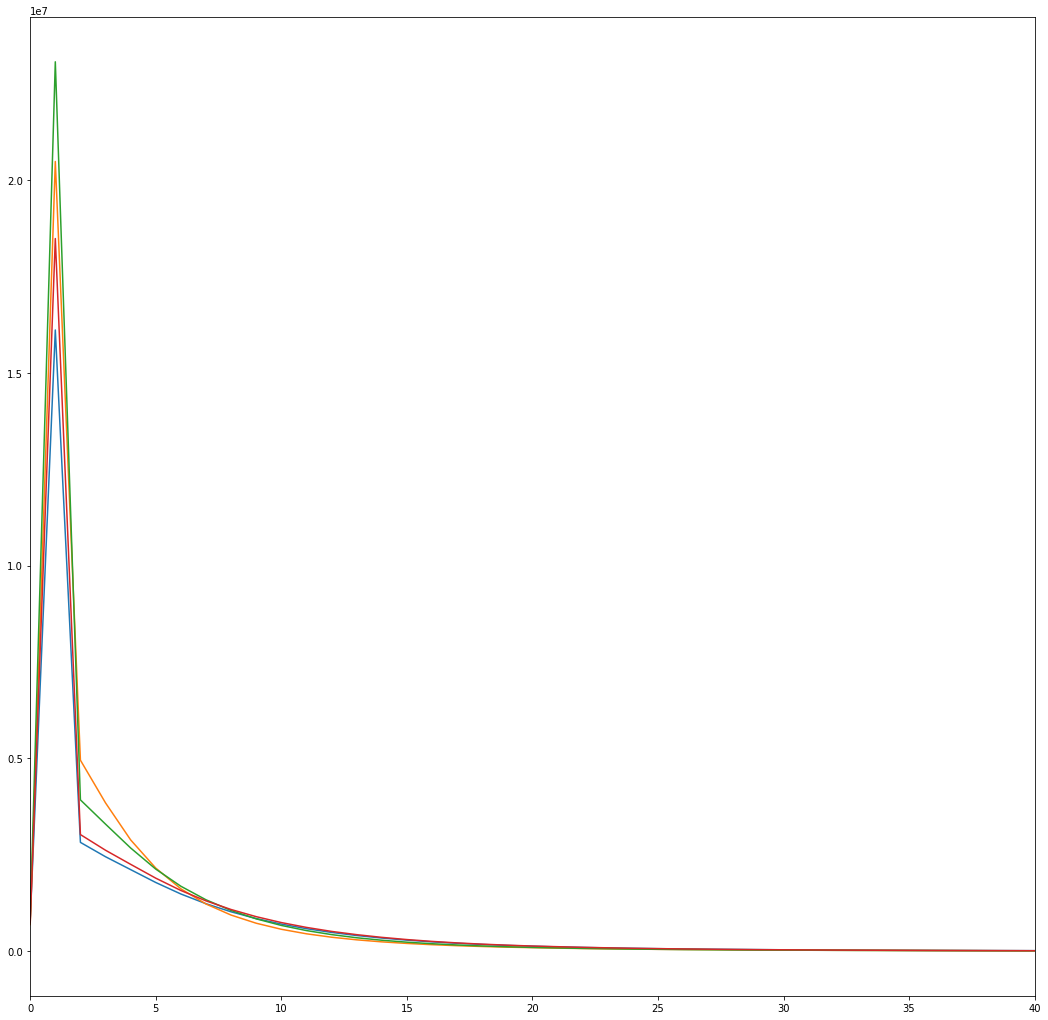

In [23]:
# Before
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(hists)):
    ax.plot(np.array(hists[i]).mean(0))
ax.set_xlim([0, 40])

(0.0, 40.0)

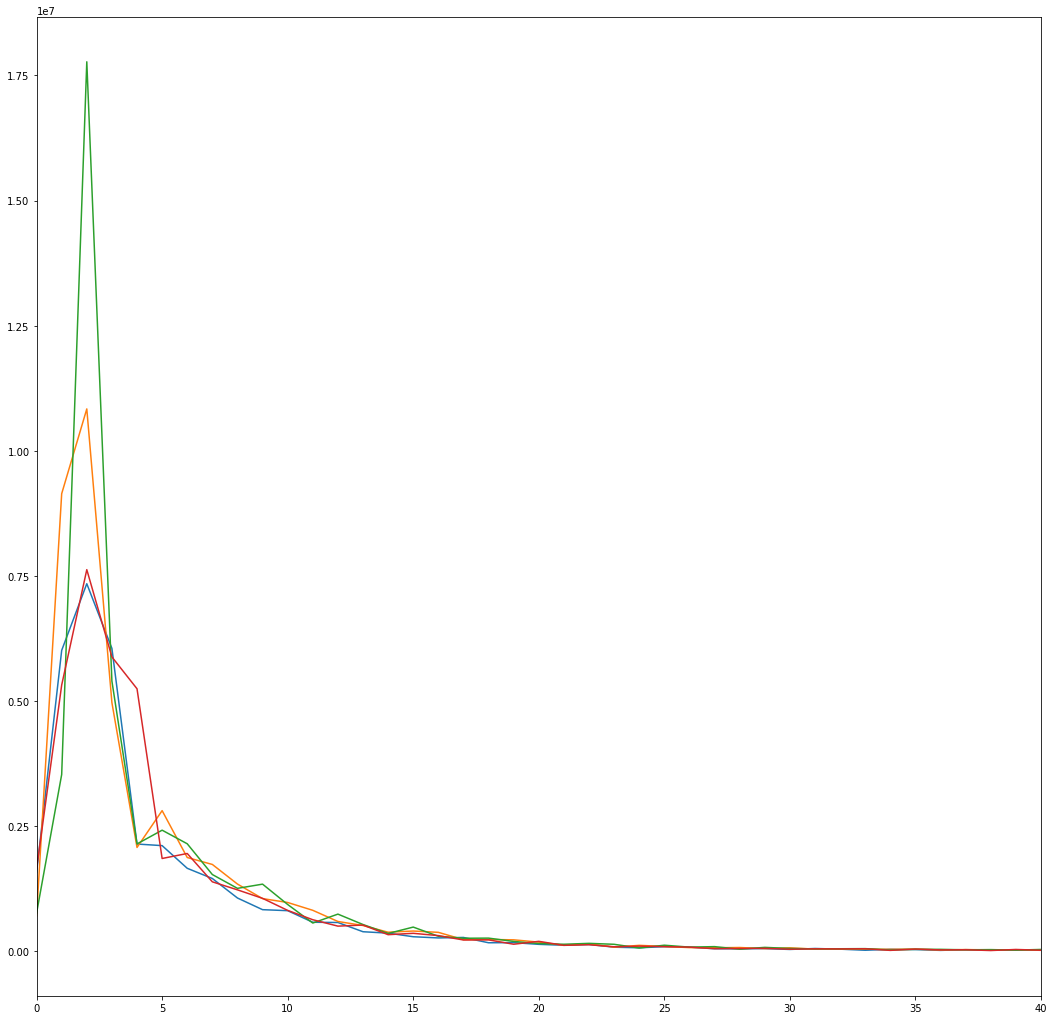

In [25]:
# After hist matching
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(hists)):
    ax.plot(np.array(hists[i]).mean(0))
ax.set_xlim([0, 40])

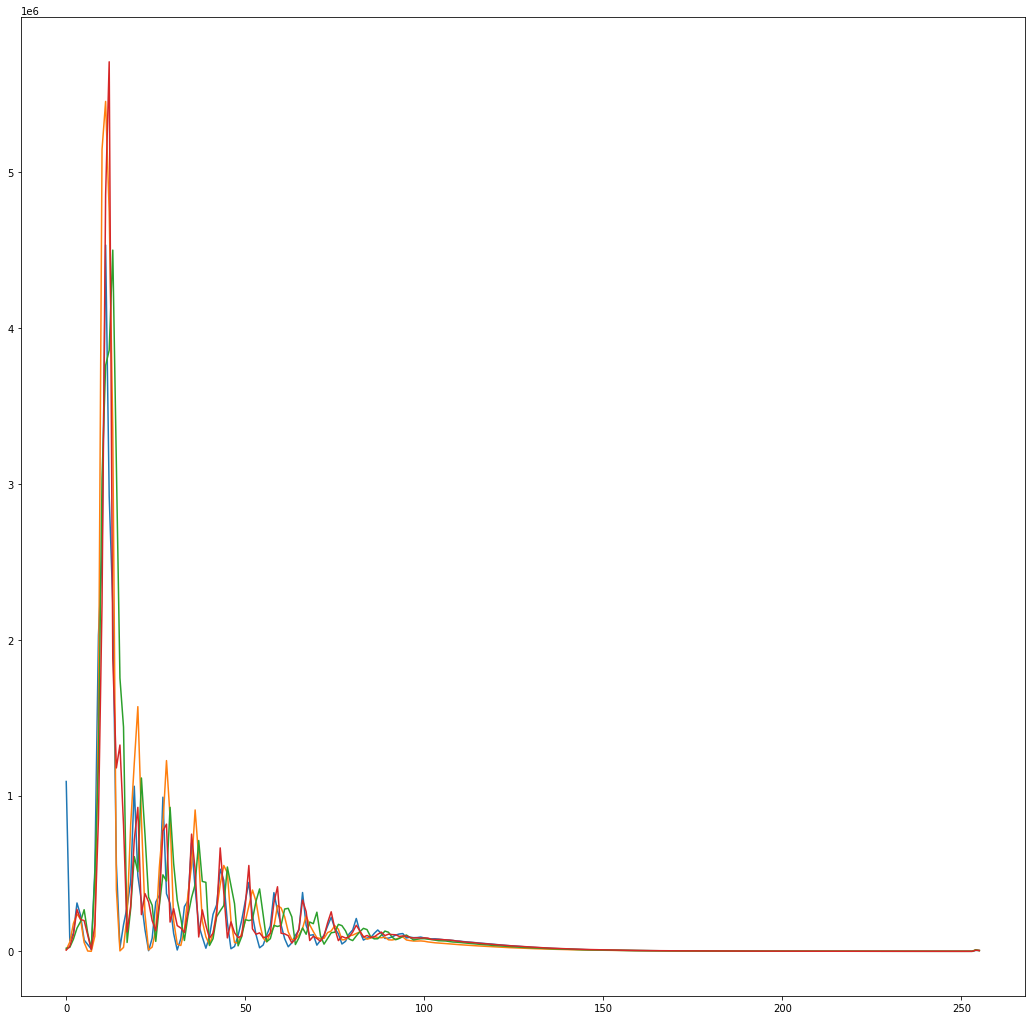

In [38]:
# After HM then AHE
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(hists)):
    ax.plot(np.array(hists[i]).mean(0))

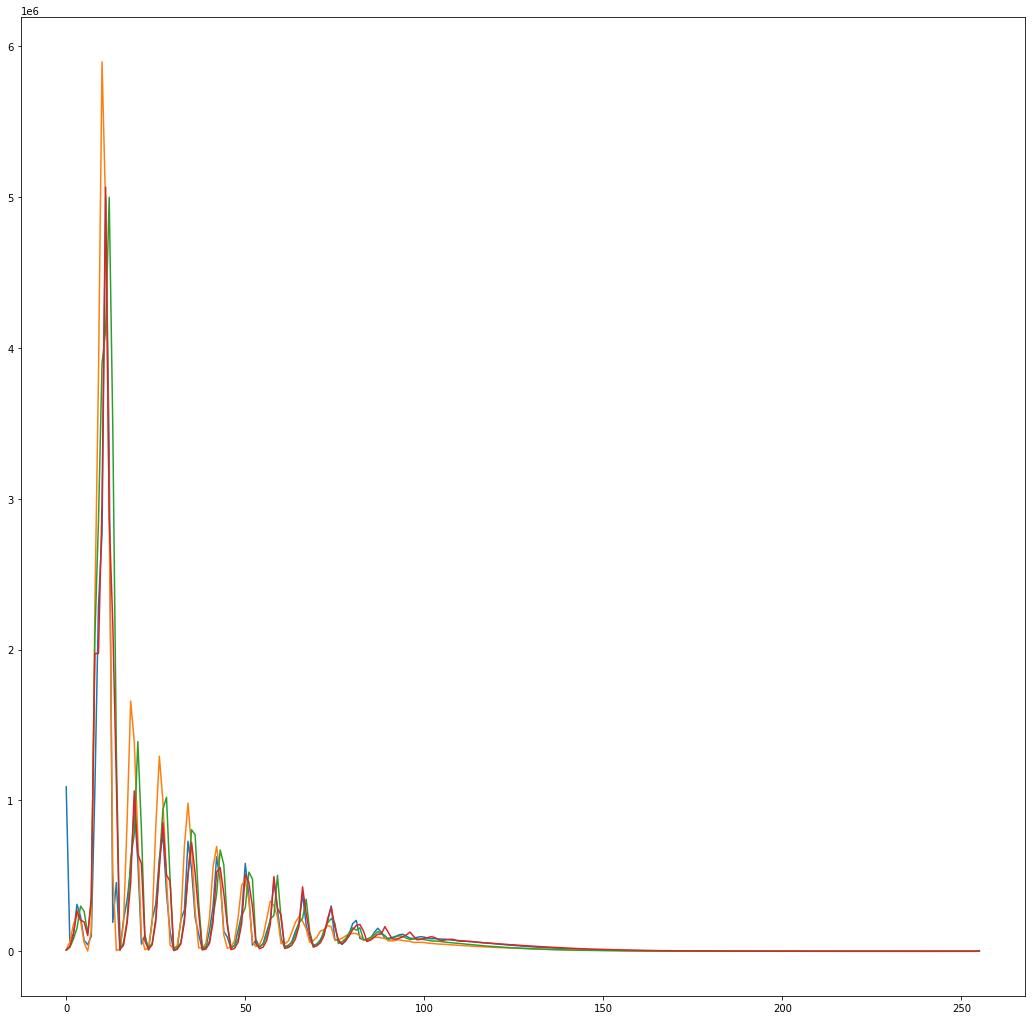

In [20]:
# Before w/ AHE
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(hists)):
    ax.plot(np.array(hists[i]).mean(0))

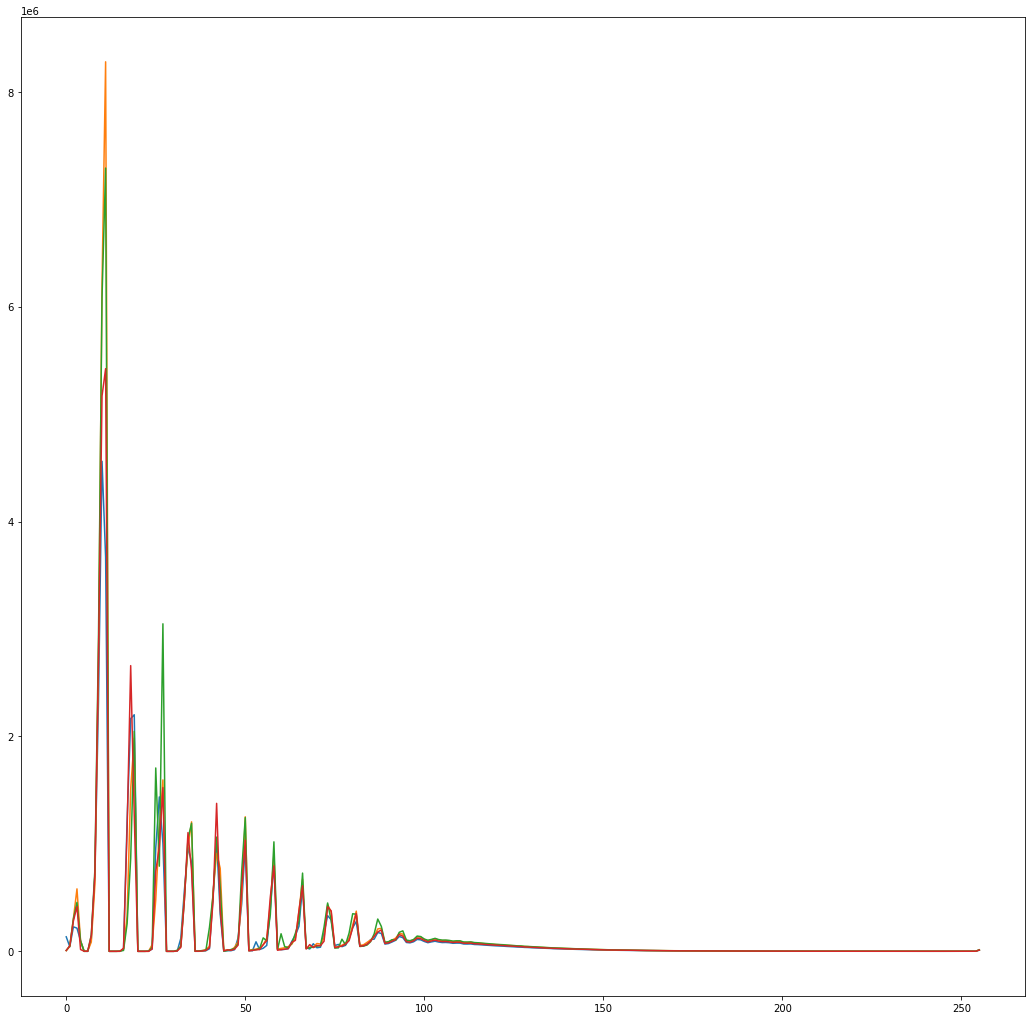

In [34]:
# After HM w/ AHE
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(hists)):
    ax.plot(np.array(hists[i]).mean(0))